# Project

### Perform cross-validation to set the Gamma/C parameters of an RBF SVM, on different datasets. Write a report on how the optimal gamma parameter is affected by characteristics of the dataset, e.g.   number  of  features  or  number  of  examples  provided  in  training  data. 

In [7]:
from sklearn import linear_model, model_selection, datasets, preprocessing, metrics
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

#### New dataset trials

In [8]:
def class_counter(labels):
    class1_count, class2_count = 0, 0

    for i in range(len(labels)):
        z = labels[0]
        if labels[i]==z:
            class1_count += 1
        else:
            class2_count += 1
        i += 1
    
    return print("Class 1: %d, Class 2: %d" % (class1_count, class2_count))

In [9]:
def splitXy(dataset):
    dataset = dataset.astype(float)
    X=dataset.iloc[:, 1:-1].values
    y=dataset.iloc[:, -1].values
    return X, y

##### ROC

In [10]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [39]:
clean_unbal = pd.read_csv('./datasets/clean_unbalanced.csv', header=None)

clean_unbal = clean_unbal.sample(frac=1).reset_index(drop=True)
X, y = splitXy(clean_unbal)

# Unfortunatley no way to scale the training and testing kfolds individually...
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X[0:2000], y[0:2000], test_size=0.5,
                                                    random_state=5)

# Learn to predict each class against the other
clf = OneVsRestClassifier(SVC(kernel='rbf', probability=True,
                                 random_state=5, C=8.2, gamma=0.244))
y_score = clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

E:\EDD\Anaconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
E:\EDD\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


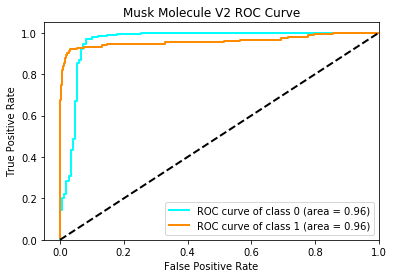

In [42]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
lw = 2
# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes-1), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Musk Molecule V2 ROC Curve')
plt.legend(loc="lower right")
plt.show()

##### Breast Cancer

In [13]:
bc = pd.read_csv('./datasets/breast-cancer-wisconsin.csv', header=None)
#print(bc.head())

print(len(bc.index))
print(len(bc.columns))

X, y = splitXy(bc)
class_counter(y)       

X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X, y, test_size=0.5, random_state=5)

clf = make_pipeline(preprocessing.MinMaxScaler(), SVC(gamma=0.06, C=8, kernel='rbf'))
clf.fit(X_train, y_train)
y_pred_decision = clf.decision_function(X_test)
hinge_loss = metrics.hinge_loss(y_test, y_pred_decision)

print(hinge_loss)

683
11
Class 1: 444, Class 2: 239
0.07353520362544286


##### wifi

In [14]:
wifi = pd.read_csv('./datasets/wifi.csv', header=None)
#print(wifi.head())

print(len(wifi.index))
print(len(wifi.columns))

X, y = splitXy(wifi)

class_counter(y)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X, y, test_size=0.5, random_state=5)

clf = make_pipeline(preprocessing.MinMaxScaler(), SVC(gamma=0.06, C=8, kernel='rbf'))
clf.fit(X_train, y_train)
y_pred_decision = clf.decision_function(X_test)
hinge_loss = metrics.hinge_loss(y_test, y_pred_decision)

print(hinge_loss)


2000
8
Class 1: 500, Class 2: 1500
0.0731903829427736


#### Banknotes 

In [15]:
bank = pd.read_csv('./datasets/data_banknote_authentication.csv', header=None)

print(len(bank.index))
print(len(bank.columns))

X, y = splitXy(bank)

class_counter(y)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X, y, test_size=0.5, random_state=5)

clf = make_pipeline(preprocessing.MinMaxScaler(), SVC(gamma=0.06, C=8, kernel='rbf'))
clf.fit(X_train, y_train)
y_pred_decision = clf.decision_function(X_test)
hinge_loss = metrics.hinge_loss(y_test, y_pred_decision)

print(hinge_loss)


1372
5
Class 1: 762, Class 2: 610
0.46745370492068505


#### Musk Molecule dataset

##### Balanced Version

In [16]:
clean_bal = pd.read_csv('./datasets/clean_balanced.csv', header=None)
#print(clean_bal.head())

print(len(clean_bal.index))
print(len(clean_bal.columns))

X, y = splitXy(clean_bal)

class_counter(y)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X, y, test_size=0.5, random_state=5)

clf = make_pipeline(preprocessing.MinMaxScaler(), SVC(gamma=0.06, C=8, kernel='rbf'))
clf.fit(X_train, y_train)
y_pred_decision = clf.decision_function(X_test)
hinge_loss = metrics.hinge_loss(y_test, y_pred_decision)

print(hinge_loss)



476
167
Class 1: 207, Class 2: 269
0.4020244947602689


##### Unbalanced version shuffled using same amount of data

In [17]:
clean_unbal = pd.read_csv('./datasets/clean_unbalanced.csv', header=None)

print(len(clean_unbal.index))
print(len(clean_unbal.columns))

clean_unbal = clean_unbal.sample(frac=1).reset_index(drop=True)
X, y = splitXy(clean_unbal)

class_counter(y)

# Uses same amount of data 
X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X[0:476], y[0:476], test_size=0.5, random_state=5)

clf = make_pipeline(preprocessing.MinMaxScaler(), SVC(gamma=0.06, C=8, kernel='rbf'))
clf.fit(X_train, y_train)
y_pred_decision = clf.decision_function(X_test)
hinge_loss = metrics.hinge_loss(y_test, y_pred_decision)

print(hinge_loss)



6598
167
Class 1: 5581, Class 2: 1017
0.16781277189889238


##### Unbalanced version using different amount of data

In [18]:
print(len(clean_unbal.index))
#Shuffling dataFrame
clean_unbal = clean_unbal.sample(frac=1).reset_index(drop=True)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X, y, test_size=0.5, random_state=5)

clf = make_pipeline(preprocessing.MinMaxScaler(), SVC(gamma=0.06, C=8, kernel='rbf'))
clf.fit(X_train, y_train)
y_pred_decision = clf.decision_function(X_test)
hinge_loss = metrics.hinge_loss(y_test, y_pred_decision)

print(hinge_loss)


6598
0.06825219451399508


### Nested CV

In [19]:
#The code below was taken from this webpage
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-
#auto-examples-model-selection-plot-nested-cross-validation-iris-py

In [30]:
clean_unbal = pd.read_csv('./datasets/clean_unbalanced.csv', header=None)
#Shuffling dataFrame
clean_unbal = clean_unbal.sample(frac=1).reset_index(drop=True)
X, y = splitXy(clean_unbal)

# Unfortunatley no way to scale the training and testing kfolds individually...
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

NUM_TRIALS = 10

# Set up possible values of parameters to optimize over
p_grid = {"C": [8, 8.2, 8.3, 8.5],
          "gamma": [0.22, 0.25, 0.27, 0.29]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Array to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)
best_C = np.zeros(NUM_TRIALS)
best_gamma = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=i)
    

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)    
    clf.fit(X[0:2000], y[0:2000])
    non_nested_scores[i] = clf.best_score_
    
    # Best C and Gamma
    best_C[i] = clf.best_estimator_.C
    best_gamma[i] = clf.best_estimator_.gamma

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X[0:2000], y[0:2000], cv=outer_cv)
    nested_scores[i] = nested_score.mean()
    
score_difference = non_nested_scores - nested_scores

print("Average difference of {0:6f} with std. dev. of {1:6f}."
      .format(score_difference.mean(), score_difference.std()))

print(np.mean(nested_score))

Average difference of 0.001500 with std. dev. of 0.000866.
0.9710000000000001


In [31]:
print(best_C)
print(np.mean(best_C))

[8.  8.  8.2 8.5 8.2 8.  8.2 8.2 8.3 8.5]
8.209999999999999


In [32]:
print(best_gamma)
print(np.mean(best_gamma))

[0.29 0.29 0.25 0.22 0.22 0.29 0.22 0.22 0.22 0.22]
0.244


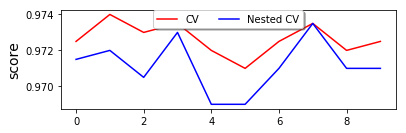

In [43]:
# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["CV", "Nested CV"],
           loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)


Text(0,0.5,'score difference')

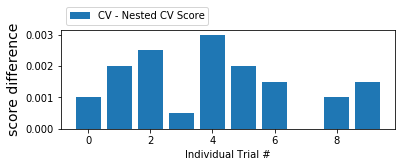

In [44]:
#Plot bar chart of the difference.
plt.subplot(211)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

##### Graphs for results

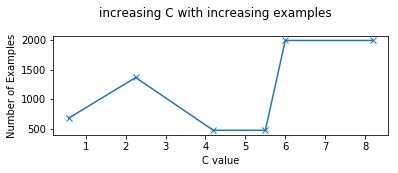

In [50]:
#Examples/c

examples = [683, 1372, 476, 476, 2000, 2000]
C = [0.57, 2.25, 4.195, 5.5, 6, 8.2]



fig = plt.figure()
fig.suptitle("increasing C with increasing examples")
plt.subplot(211)
plt.errorbar(x=C, y=examples, marker='x')

plt.xlabel('C value')
plt.ylabel('Number of Examples')
plt.show()

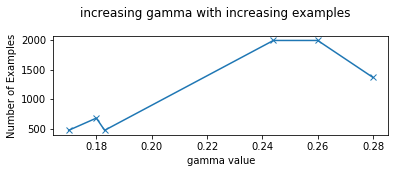

In [54]:
#Examples/gamma
examples = [476, 683, 476, 2000, 2000, 1372]
gamma = [0.17, 0.18, 0.183, 0.244, 0.26, 0.28]

fig = plt.figure()
fig.suptitle("increasing gamma with increasing examples")
plt.subplot(211)
plt.errorbar(x=gamma, y=examples, marker='x')

plt.xlabel('gamma value')
plt.ylabel('Number of Examples')
plt.show()


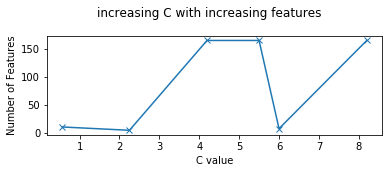

In [52]:
#Features/c
features = [10, 4, 166, 166, 7, 166]
C = [0.57, 2.25, 4.195, 5.5, 6, 8.2]

fig = plt.figure()
fig.suptitle("increasing C with increasing features")
plt.subplot(211)
plt.errorbar(x=C, y=features, marker='x')

plt.xlabel('C value')
plt.ylabel('Number of Features')
plt.show()



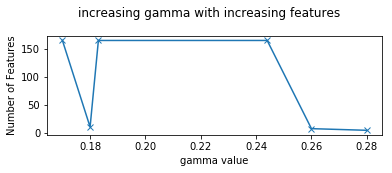

In [53]:
#Features/g

features = [166, 10, 166, 166, 7, 4]
gamma = [0.17, 0.18, 0.183, 0.244,  0.26, 0.28]

fig = plt.figure()
fig.suptitle("increasing gamma with increasing features")
plt.subplot(211)
plt.errorbar(x=gamma, y=features, marker='x')

plt.xlabel('gamma value')
plt.ylabel('Number of Features')
plt.show()
